# Risk Score

## Read in the data

In [ ]:
base_dir = '/Users/csowers/Documents/Job prep/DataSF'

fire_incidents = pd.read_csv(os.path.join(base_dir, 'Fire_Incidents_20250923.csv'))
fire_inspections = pd.read_csv(os.path.join(base_dir, 'Fire_Inspections_20250923.csv'))
fire_violations = pd.read_csv(os.path.join(base_dir, 'Fire_Violations_20250923.csv'))

fire_incidents = fire_incidents.rename(columns={'point': 'Location'})
fire_inspections = fire_inspections.rename(columns={'location': 'Location'})

properties = pd.read_csv(os.path.join(base_dir, 'Assessor_Historical_Secured_Property_Tax_Rolls_20250923.csv'))
parcel_data = pd.read_csv(os.path.join(base_dir, 'Parcels_–_Active_and_Retired_20250923.csv'))

In [1082]:
# subset for R2 properties only
R2_properties_parcel = id_residential_properties(properties, parcel_data)

## Feature Generation

In [1083]:
# compute fire incident stats for the last five years
current_year = 2024
time_range = 4

fire_incidents = fire_incidents.rename(columns={'point': 'Location'})
fire_incidents['Incident Date'] = pd.to_datetime(fire_incidents['Incident Date'])
fire_incidents = fire_incidents[fire_incidents['Incident Date'].dt.year>= (current_year-time_range)]
fire_incident_stats = compute_fire_incident_stats(fire_incidents)

In [1084]:
fire_violations_risk = fire_violations.copy()
fire_violations_risk['Violation Date'] = pd.to_datetime(fire_violations_risk['Violation Date'])
fire_violations_risk = fire_violations_risk[fire_violations_risk['Violation Date'].dt.year>= (current_year-time_range)]

In [1085]:
# compute fire violation stats for the last five years
fire_violations['Violation Date'] = pd.to_datetime(fire_violations['Violation Date'])
fire_violations = fire_violations[fire_violations['Violation Date'].dt.year>= (current_year-time_range)]

fire_violations_stats = compute_fire_violation_stats(fire_violations)

In [1086]:
# combine fire features 
fire_data = pd.merge(fire_incident_stats, fire_violations_stats, on='Location', how='outer')
fire_data = fire_data.fillna(0)

In [1087]:
# merge property data
incident_pts = fire_incidents[['Address', 'Location']][~fire_incidents['Location'].isna()]
inspection_pts = fire_inspections[['Address', 'Location']][~fire_inspections['Location'].isna()]
violation_pts = fire_violations[['Address', 'Location']][~fire_violations['Location'].isna()]

fire_pts = pd.concat([incident_pts, inspection_pts, violation_pts])
fire_pts = fire_pts.drop_duplicates(subset=['Location'])

# assign Location coords to Parcel Number for merging
point_parcel_map = map_points_to_parcel(R2_properties_parcel, fire_pts)

fire_data['Location'] = fire_data['Location'].apply(wkt.loads)
fire_data = fire_data.merge(point_parcel_map, on='Location', how='right')
fire_data = fire_data.fillna(0)

fire_data = fire_data.merge(R2_properties_parcel[['Parcel Number', 'Year Property Built', 'Number of Stories', 'Number of Units', 'Property Class Code Definition']], on='Parcel Number', how='left')

In [1088]:
# assign risk score
fire_data_risk_scores = assign_risk_scores(fire_data)

In [1090]:
# include station data in table
fire_violations_sub = fire_violations[['Location', 'Station Area']].drop_duplicates()
fire_violations_sub = fire_violations_sub.dropna()
fire_violations_sub['Location'] = fire_violations_sub['Location'].apply(wkt.loads)
fire_data = fire_data.merge(fire_violations_sub, on='Location', how='left')

In [1091]:
fire_data.to_csv(os.path.join(base_dir, 'fire_risk.csv'), index=False)

## Results

In [1100]:
fire_data_risk_scores.sort_values(by='risk_score', ascending=False).head()

,Location,Fire Fatalities,Fire Injuries,High Alarm Incidents,Low Alarm Incidents,Violation Number,Open Violation Number,Address,Parcel Number,Year Property Built,Number of Stories,Number of Units,Property Class Code Definition,risk_score
89,POINT (-122.413644 37.784092),0.0,0.0,1.0,109.0,0.0,0.0,364 EDDY STREET,0333011,1909.0,5.0,86.0,Hotels - Other,8
183,POINT (-122.398171 37.796704),0.0,0.0,1.0,39.0,0.0,0.0,440 DAVIS COURT,0200014,1966.0,22.0,460.0,Apartment 15 Units or more,7
419,POINT (-122.418823 37.783411),0.0,0.0,0.0,73.0,0.0,0.0,670 EDDY STREET,0740013,1907.0,4.0,96.0,Residential Hotel & SRO,6
45,POINT (-122.410263 37.784502),0.0,0.0,0.0,55.0,0.0,0.0,160 EDDY STREET,0331009,1908.0,4.0,110.0,Hotels - Other,6
165,POINT (-122.411601 37.785569),0.0,0.0,0.0,36.0,0.0,0.0,345 TAYLOR STREET,0324002,1926.0,9.0,114.0,Hotels - Other,6


In [1092]:
# examining risk scores of properties in Fire Station Area 40
fire_data[fire_data['Station Area']=='40'].sort_values(by='risk_score', ascending=False)

,Location,Fire Fatalities,Fire Injuries,High Alarm Incidents,Low Alarm Incidents,Violation Number,Open Violation Number,Address,Parcel Number,Year Property Built,Number of Stories,Number of Units,Property Class Code Definition,risk_score,Station Area
5084,POINT (-122.47617612 37.74531684),0.0,0.0,0.0,0.0,2.0,1.0,2275 19th Ave,2330006,1927.0,3.0,17.0,Apartment 15 Units or more,2,40
7151,POINT (-122.47718629 37.7570284),0.0,0.0,0.0,0.0,0.0,0.0,1601 19th Ave,1924004,2002.0,4.0,120.0,Apartment 4 units or less,2,40
1734,POINT (-122.48375361 37.74244799),0.0,0.0,0.0,0.0,4.0,4.0,1633 - 1639 Taraval St,2399041,1991.0,3.0,9.0,Apartment 5 to 14 Units,1,40
7567,POINT (-122.48465624 37.74356917),0.0,0.0,0.0,0.0,0.0,0.0,2349 27th Ave,2356002,1926.0,2.0,6.0,Apartment 5 to 14 Units,1,40
2750,POINT (-122.48410381 37.74292769),0.0,0.0,0.0,0.0,0.0,0.0,2396 27th Ave,2355013,1956.0,2.0,8.0,Apartment 5 to 14 Units,0,40
4199,POINT (-122.46698499 37.7535503),0.0,0.0,0.0,0.0,0.0,0.0,1855 10th Ave,2047057,1961.0,3.0,18.0,Apartment 15 Units or more,0,40
4702,POINT (-122.4762045 37.75581031),0.0,0.0,0.0,0.0,0.0,0.0,1710 19th Ave,2031026,1965.0,3.0,11.0,Apartment 5 to 14 Units,0,40
7383,POINT (-122.47973927 37.74262442),0.0,0.0,0.0,0.0,0.0,0.0,1255 Taraval St,2403033,1961.0,3.0,18.0,Apartment 4 units or less,0,40


In [1093]:
fire_data['risk_score'].value_counts()

risk_score
1    6844
2    2277
0    2233
3     816
4     354
5      80
6      34
8       1
7       1
Name: count, dtype: int64

# Predicting Future Violations

In [ ]:
base_dir = '/Users/csowers/Documents/Job prep/DataSF'

fire_incidents = pd.read_csv(os.path.join(base_dir, 'Fire_Incidents_20250923.csv'))
fire_inspections = pd.read_csv(os.path.join(base_dir, 'Fire_Inspections_20250923.csv'))
fire_violations = pd.read_csv(os.path.join(base_dir, 'Fire_Violations_20250923.csv'))

fire_incidents = fire_incidents.rename(columns={'point': 'Location'})
fire_inspections = fire_inspections.rename(columns={'location': 'Location'})

In [1483]:
current_year = 2024
time_range = 5
fire_incidents = fire_incidents.rename(columns={'point': 'Location'})
fire_incidents['Incident Date'] = pd.to_datetime(fire_incidents['Incident Date'])
fire_incidents = fire_incidents[fire_incidents['Incident Date'].dt.year>= (current_year-time_range)]

# pull out year of violation
fire_incidents['Year'] = fire_incidents['Incident Date'].dt.year

fire_incident_stats = compute_fire_incident_stats(fire_incidents, per_year=True)

In [1484]:
fire_violations_risk = fire_violations.copy()
fire_violations_risk['Violation Date'] = pd.to_datetime(fire_violations_risk['Violation Date'])
fire_violations_risk = fire_violations_risk[fire_violations_risk['Violation Date'].dt.year>= (current_year-time_range+1)]

# pull out year of violation
fire_violations_risk['Year'] = fire_violations_risk['Violation Date'].dt.year

# generate stats per year
fire_violations_stats = compute_fire_violation_stats(fire_violations_risk, per_year=True)

In [1485]:
# combine fire features 
fire_data = pd.merge(fire_incident_stats, fire_violations_stats, on=['Location', 'Year'], how='outer')
fire_data = fire_data.fillna(0)

In [1486]:
# add property data
fire_data['Location'] = fire_data['Location'].apply(wkt.loads)
fire_data = fire_data.merge(point_parcel_map, on='Location', how='right')
fire_data = fire_data.fillna(0)

fire_data = fire_data.merge(R2_properties_parcel[['Parcel Number', 'Year Property Built', 'Number of Stories', 'Number of Units', 'Property Class Code Definition']], on='Parcel Number', how='left')
fire_data.to_csv(os.path.join(base_dir, 'fire_risk_yearly.csv'))

In [1522]:
# create target variable aka violation next year
fire_data['Location'] = fire_data['Location'].astype(str)
fire_data = fire_data.sort_values(by=["Location", "Year"])

fire_data_next = fire_data[["Location", "Year", "Violation Number"]].copy()
fire_data_next["Year"] = fire_data_next["Year"] - 1   # shift year down to match "current" year
fire_data_next = fire_data_next.rename(columns={"Violation Number": "violation_next_yr"})
fire_data_merged = fire_data.merge(fire_data_next, on=["Location", "Year"], how="left")

# binarize and drop na
fire_data_merged["violation_next_yr_binary"] = (fire_data_merged["violation_next_yr"] > 0).astype(int)
fire_data_merged = fire_data_merged.dropna(subset=["violation_next_yr_binary"]).copy()


features = [
    "Fire Fatalities", "Fire Injuries",
    "High Alarm Incidents", "Low Alarm Incidents",
    "Violation Number", "Open Violation Number",
    "Year Property Built", "Number of Stories", "Number of Units"
]

log_reg, y_test, y_pred, y_proba = classify_property_violations(
    fire_data_merged, target_var="violation_next_yr_binary", features=features, threshold = 0.95)

## Results

In [1528]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", acc)
print("ROC AUC:", roc)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)


Accuracy: 0.9353562005277045
ROC AUC: 0.9557171437365343
Confusion Matrix:
 [[679  43]
 [  6  30]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.94      0.97       722
           1       0.41      0.83      0.55        36

    accuracy                           0.94       758
   macro avg       0.70      0.89      0.76       758
weighted avg       0.96      0.94      0.95       758



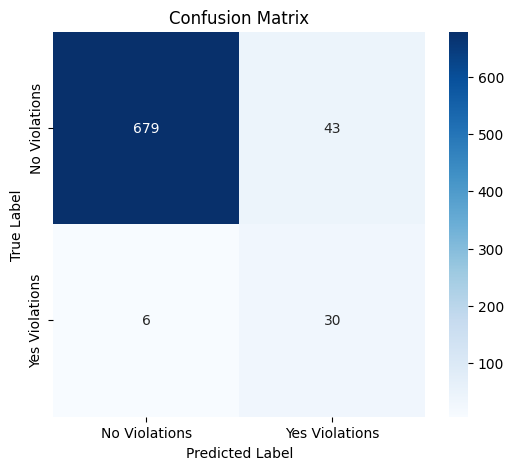

In [1530]:
class_labels = ['No Violations', 'Yes Violations'] # Replace with your actual class labels
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [1525]:
feature_rank = pd.DataFrame({
    'feature': features,
    'coefficient': log_reg.coef_[0]
}).sort_values(by='coefficient', key=abs, ascending=False)

print(feature_rank)

                 feature  coefficient
5  Open Violation Number     8.571249
3    Low Alarm Incidents    -1.072660
4       Violation Number     0.142578
8        Number of Units     0.005943
2   High Alarm Incidents    -0.003387
7      Number of Stories     0.003365
6    Year Property Built     0.001295
0        Fire Fatalities     0.000000
1          Fire Injuries     0.000000


# K-means Clustering

In [1535]:
X = pd.read_csv('/Users/csowers/Documents/Job prep/DataSF/fire_risk.csv')
X = X.dropna()

# drop outlier, likely reporting error
X = X[X['Number of Stories']<100]
X_adj = X.drop(columns=['Location', 'Address', 'Parcel Number', 'Property Class Code Definition', 'risk_score'])

In [1543]:
X

,Location,Fire Fatalities,Fire Injuries,High Alarm Incidents,Low Alarm Incidents,Violation Number,Open Violation Number,Address,Parcel Number,Year Property Built,Number of Stories,Number of Units,Property Class Code Definition,risk_score,Station Area,cluster
1491,POINT (-122.42811091 37.79735732),0.0,0.0,0.0,0.0,14.0,1.0,1770 Green St,0544005,1931.0,6.0,26.0,Apartment 15 Units or more,3,16.0,1
1492,POINT (-122.4137939 37.78801998),0.0,0.0,0.0,0.0,2.0,1.0,729 Jones St,0299002,1910.0,5.0,79.0,Apartment 15 Units or more,4,3.0,1
1493,POINT (-122.4479079 37.78473038),0.0,0.0,0.0,0.0,1.0,1.0,59 Lupine Ave,1057024,1962.0,6.0,22.0,Apartment 15 Units or more,2,10.0,1
1494,POINT (-122.42303418 37.79934218),0.0,0.0,0.0,0.0,2.0,1.0,1455 Filbert St,0526022,1960.0,3.0,36.0,Apartment 15 Units or more,2,41.0,0
1495,POINT (-122.42095842 37.75835142),0.0,0.0,0.0,0.0,6.0,4.0,901 - 909 Valencia St,3609042,1908.0,4.0,28.0,Apartment 15 Units or more,4,7.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12588,POINT (-122.42296616 37.75893539),0.0,0.0,0.0,0.0,0.0,0.0,172 - 182 Linda St,3597046,1907.0,3.0,6.0,Apartment 4 units or less,1,7.0,1
12593,POINT (-122.44316123 37.75333791),0.0,0.0,0.0,0.0,0.0,0.0,833 Corbett Ave,2778034,1967.0,5.0,5.0,Apartment 4 units or less,1,24.0,0
12606,POINT (-122.44914246 37.78188823),0.0,0.0,0.0,0.0,0.0,0.0,2801 - 2807 Geary Blvd,1091001,1900.0,2.0,3.0,Flat & Store 4 units or less,1,10.0,1
12617,POINT (-122.43230557 37.77442262),0.0,0.0,0.0,0.0,0.0,0.0,542 - 546 Steiner St,0827021,1900.0,3.0,6.0,Apartment 5 to 14 Units,1,5.0,1


In [1536]:
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X_adj)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
X["cluster"] = clusters

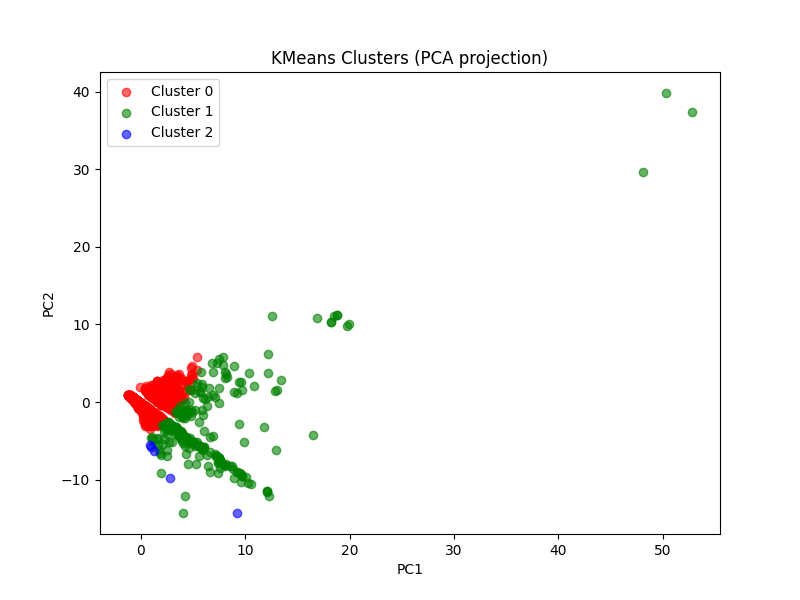

In [1549]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# assume X_scaled is your standardized data and clusters are your kmeans labels
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))

# Get unique cluster labels
unique_clusters = np.unique(clusters)
colors = ['red', 'green', 'blue']  # one color per cluster

for i, cluster in enumerate(unique_clusters):
    plt.scatter(
        X_pca[clusters == cluster, 0],
        X_pca[clusters == cluster, 1],
        label=f"Cluster {cluster}",
        color=colors[i],
        alpha=0.6
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans Clusters (PCA projection)")
plt.legend()  # add legend instead of colorbar
plt.show()


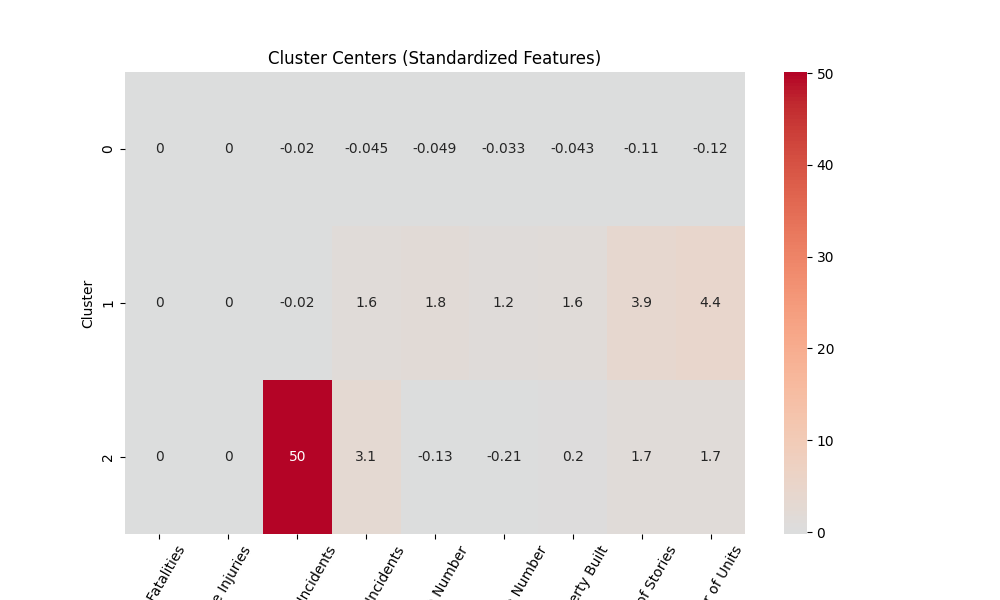

In [1550]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=X_adj.columns)
plt.figure(figsize=(10,6))
sns.heatmap(centers, annot=True, cmap="coolwarm", center=0)
plt.title("Cluster Centers (Standardized Features)")
plt.xticks(rotation=60)
plt.ylabel("Cluster")
plt.show()

## DBI Exploration

In [513]:
#dbi_complaints = pd.read_csv(os.path.join(base_dir, 'Department_of_Building_Inspection_Complaints_(All_Divisions)_20250923.csv'))
#dbi_violations = pd.read_csv(os.path.join(base_dir, 'Notices_of_Violation_issued_by_the_Department_of_Building_Inspection_20250923.csv'))

# clean data
dbi_complaints = dbi_complaints[dbi_complaints['Date Filed'].str[-4]!='0']
dbi_complaints = dbi_complaints.rename(columns={'point': 'Location'})
dbi_complaints['Date Filed'] = pd.to_datetime(dbi_complaints['Date Filed'])

In [514]:
#compute building complaints for the last five years
current_year = 2024
time_range = 5

dbi_complaints = dbi_complaints[dbi_complaints['Date Filed'].dt.year>= (current_year-time_range)]

In [521]:
dbi_complaints_stats = dbi_complaints[['Location', 'Complaint Number']].groupby(by=['Location']).count().reset_index()
dbi_complaints_open = dbi_complaints[dbi_complaints.Status=='Active']
dbi_complaints_open = dbi_complaints_open[['Location', 'Complaint Number']].groupby(by=['Location']).count().reset_index()
dbi_complaints_open = dbi_complaints_open.rename(columns={'Complaint Number': 'Active Complaint Number'})

In [526]:
all_dbi_complaints = pd.merge(dbi_complaints_stats, dbi_complaints_open, on='Location', how='outer').fillna(0)

In [500]:
dbi_complaints_stats = dbi_complaints[['Location', 'Complaint Number']].groupby(by=['Location']).count().reset_index()

## Data Visualizations

Text(0, 0.5, 'Frequency')

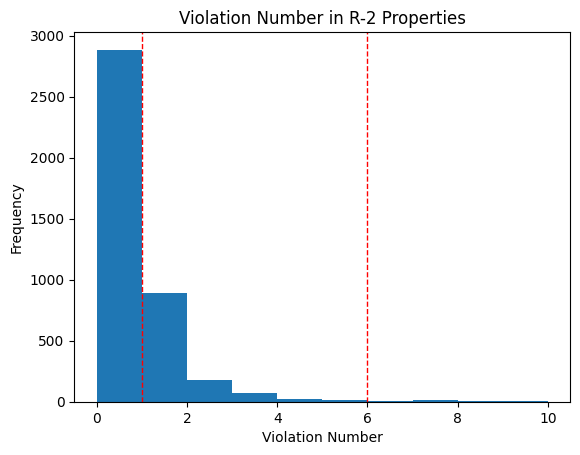

In [1467]:
import matplotlib.pyplot as plt
desired_bin_width = 1
min_val, max_val = 0, 10
bins = np.arange(min_val, max_val + desired_bin_width, desired_bin_width)

low_mean = fire_data['Violation Number'].mean()

plt.hist(fire_data['Violation Number'], bins=bins)
#plt.xlim(min_val, max_val)
plt.axvline(round(low_mean), color='red', linestyle='dashed', linewidth=1)
plt.axvline(round(np.percentile(fire_data['Violation Number'], 99)), color='red', linestyle='dashed', linewidth=1)
plt.title('Violation Number in R-2 Properties')
plt.xlabel('Violation Number')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

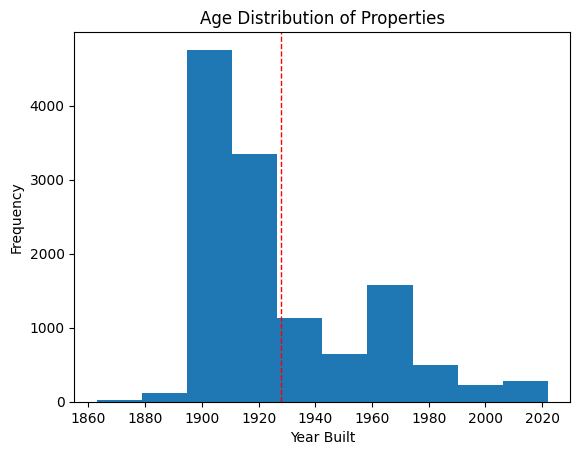

In [1094]:
import matplotlib.pyplot as plt

low_mean = fire_data['Year Property Built'].mean()

plt.hist(fire_data['Year Property Built'])
plt.axvline(round(low_mean), color='red', linestyle='dashed', linewidth=1)
#plt.axvline(round(np.percentile(fire_data['Number of Units'], 99)), color='red', linestyle='dashed', linewidth=1)
plt.title('Age Distribution of Properties')
plt.xlabel('Year Built')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

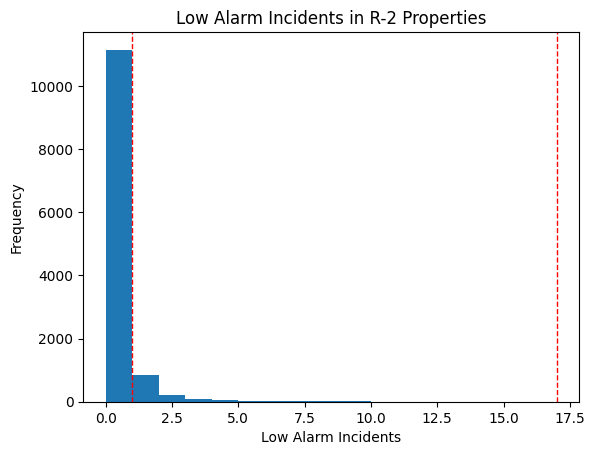

In [1095]:
import matplotlib.pyplot as plt
desired_bin_width = 1
min_val, max_val = 0, 10
bins = np.arange(min_val, max_val + desired_bin_width, desired_bin_width)

low_mean = fire_data['Low Alarm Incidents'].mean()

plt.hist(fire_data['Low Alarm Incidents'], bins=bins)
#plt.xlim(min_val, max_val)
plt.axvline(round(low_mean), color='red', linestyle='dashed', linewidth=1)
plt.axvline(round(np.percentile(fire_data['Low Alarm Incidents'], 99)), color='red', linestyle='dashed', linewidth=1)
plt.title('Low Alarm Incidents in R-2 Properties')
plt.xlabel('Low Alarm Incidents')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

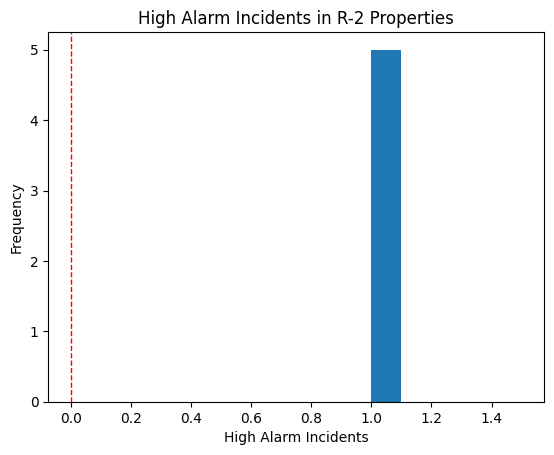

In [1096]:
hi_mean = fire_data['High Alarm Incidents'].mean()

plt.hist(fire_data[fire_data['High Alarm Incidents']>0]['High Alarm Incidents'])
plt.axvline(round(hi_mean), color='red', linestyle='dashed', linewidth=1)
plt.title('High Alarm Incidents in R-2 Properties')
plt.xlabel('High Alarm Incidents')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

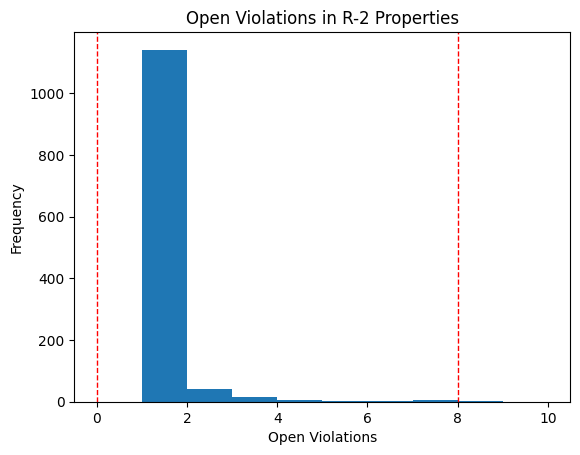

In [1342]:
open_mean = fire_data['Open Violation Number'].mean()

desired_bin_width = 1
min_val, max_val = 0, 10
bins = np.arange(min_val, max_val + desired_bin_width, desired_bin_width)


plt.hist(fire_data[fire_data['Open Violation Number']>0]['Open Violation Number'], bins=bins)
plt.axvline(round(open_mean), color='red', linestyle='dashed', linewidth=1)
plt.axvline(round(np.percentile(fire_data['Open Violation Number'], 99.9)), color='red', linestyle='dashed', linewidth=1)
plt.title('Open Violations in R-2 Properties')
plt.xlabel('Open Violations')
plt.ylabel('Frequency')